<a href="https://colab.research.google.com/github/VinayakMaharaj/STA365-Final-Project/blob/main/Proj_test_code_JM_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the 'random' module, which includes functions for generating random numbers
import random

# Import the 'numpy' module as 'np', a fundamental package for scientific computing in Python
import numpy as np

# Import the 'stats' module from the 'scipy' library, which contains a large number of probability distributions as well as a growing library of statistical functions
from scipy import stats

# Import the 'pandas' module as 'pd', which is used for data manipulation and analysis
import pandas as pd

# Import the 'matplotlib.pyplot' module as 'plt', which is a collection of functions that make matplotlib work like MATLAB, useful for creating static, interactive, and animated visualizations in Python
import matplotlib.pyplot as plt

# Import the 'requests' module, used for making HTTP requests to a specified URL
import requests

# Import the 'pymc' module as 'pm', a Python library for probabilistic programming that allows for Bayesian statistical modeling and probabilistic machine learning
import pymc as pm

# Import the 'arviz' module as 'az', a package for exploratory analysis of Bayesian models that includes functions for posterior analysis, model checking, comparison, and diagnostics
import arviz as az

# From the 'pymc.math' module, import the 'invlogit' function as 'tt_invlogit', which computes the inverse logit (logistic) function, often used in logistic regression models
from pymc.math import invlogit as tt_invlogit

# Load a CSV file named 'hhs_filter.csv' into a pandas DataFrame called 'df'. This is often used for data preprocessing or analysis.
df = pd.read_csv('hhs_filter.csv')


Dataset is a log of shot attempts made by the top 15 NBA players in the 2014-15 season who made the most "hot-hand shots".

Our project defines "hot-hand shot" as any shot made by a player after the player has made their last 3 consecutive shots.

In [2]:
print(df.head(n=5))

   Unnamed: 0   GAME_ID LOCATION  SHOT_NUMBER  PERIOD  GAME_HALF GAME_CLOCK  \
0           0  21400907        H            1       1          1       9:49   
1           1  21400907        H            2       1          1       7:26   
2           2  21400907        H            3       1          1       5:34   
3           3  21400907        H            4       1          1       5:00   
4           4  21400907        H            5       1          1       3:33   

   GAME_CLOCK_DECIMAL  SHOT_CLOCK  DRIBBLES  ...  PLAYER_WEIGHT  EXCLUDE  \
0            9.816667        16.3         2  ...       86.18248        1   
1            7.433333        16.6         0  ...       86.18248        1   
2            5.566667        11.0         0  ...       86.18248        1   
3            5.000000        18.5         2  ...       86.18248        1   
4            3.550000         NaN         1  ...       86.18248        1   

  SEASON_SHOTS_TAKEN GAME_SHOTS_TAKEN  SHOT_STREAK  HOT_HAND_SHOT_ST

In [3]:
#need to remove some variables we dont need for the analysis, we helpful when creating the dataset
df2 = df.iloc[:, 1:]

df3 = df2.drop(columns= ["GAME_ID", "GAME_CLOCK","SHOT_STREAK", "GAME_HALF",
                           "player_name", "player_id", "GAME_SHOTS_TAKEN",
                           "SHOT_RESULT", "REFORMATED_DEF_NAME",
                           "CLOSEST_DEFENDER_PLAYER_ID", "SEASON_SHOTS_TAKEN" ])

#remove any rows that have some kind of error we have flagged that cannot be find with generative modeling
df3 = df3[df3.EXCLUDE == 0]

#no longer need exclude and fgm column
clean = df3.drop(columns= ["EXCLUDE"])

# replace 'A' with '0'
clean['LOCATION'].replace('A', 0, inplace=True)
# replace 'A' with '0'
clean['LOCATION'].replace('H', 1, inplace=True)
# when shot clock is NaN, we will replace shot clock with game clock value
clean.loc[df['SHOT_CLOCK'].isnull(),'SHOT_CLOCK'] = df['GAME_CLOCK_DECIMAL']

print(clean.head(n=5))

    LOCATION  SHOT_NUMBER  PERIOD  GAME_CLOCK_DECIMAL  SHOT_CLOCK  DRIBBLES  \
16         0            1       1            6.266667        15.4         0   
17         0            2       1            5.383333        16.2        11   
18         0            3       1            5.233333        18.2         0   
19         0            4       3            9.200000        12.1         0   
20         0            5       3            2.100000        19.4         4   

    SHOT_DIST  PTS_TYPE  DEFENDER_HEIGHT_CM  DEFENDER_WEIGHT_KG  \
16       23.2         3              190.50            90.71840   
17       15.6         2              190.50            86.18248   
18       23.1         3              198.12            99.79024   
19       24.6         3              190.50            90.71840   
20       25.7         3              190.50            90.71840   

    CLOSE_DEF_DIST  FGM  PLAYER_HEIGHT  PLAYER_WEIGHT  HOT_HAND_SHOT_STREAK2  \
16             4.1    0          190.5    

In [4]:
len(clean)
# number of total obs and number of "hot hand shots taken"
print(len(clean), 'and', sum(clean['HOT_HAND_SHOT_STREAK3']))

13579 and 995


In [5]:
np.random.seed(23)
N = 250 #number of samples to make code run faster

#force 250 shots to be hot
# will divide the sample dataset into 2 subdatasets
base = clean[(clean.HOT_HAND_SHOT_STREAK3 ==0)].sample(N, replace=False)
hot = clean[(clean.HOT_HAND_SHOT_STREAK3 ==1) ].sample(N, replace = False)

samp = pd.concat([base,hot])

#maybe only for players with high number of hot hand shots
#removes noise and focuses the inference and justifaction fo smaller

print(samp.head(n=5))



       LOCATION  SHOT_NUMBER  PERIOD  GAME_CLOCK_DECIMAL  SHOT_CLOCK  \
4499          1            6       2            2.133333        13.8   
532           1           11       3            7.666667        19.0   
4163          0           16       4            4.433333        10.1   
4126          0           13       3            9.983333         9.5   
11441         1            7       3            8.250000        15.0   

       DRIBBLES  SHOT_DIST  PTS_TYPE  DEFENDER_HEIGHT_CM  DEFENDER_WEIGHT_KG  \
4499          1        5.5         2              195.58          102.058200   
532           6       24.0         3              182.88           79.378600   
4163          0        2.0         2              193.04           88.450440   
4126          2        5.2         2              200.66          104.326160   
11441         9       24.9         3              205.74          102.965384   

       CLOSE_DEF_DIST  FGM  PLAYER_HEIGHT  PLAYER_WEIGHT  \
4499              3.9    1

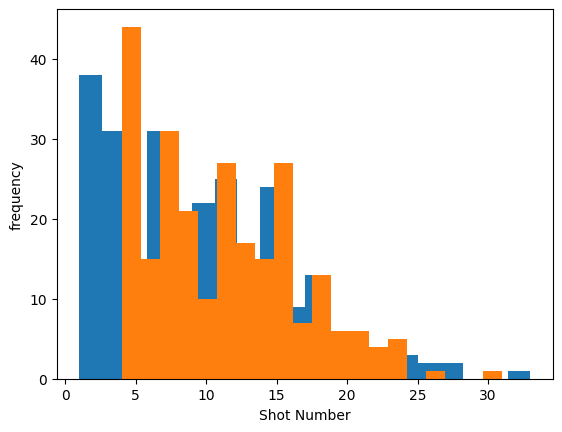

In [6]:
# Exploratory Data Analysis
plt.hist(base['SHOT_NUMBER'],bins=20)
plt.hist(hot['SHOT_NUMBER'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

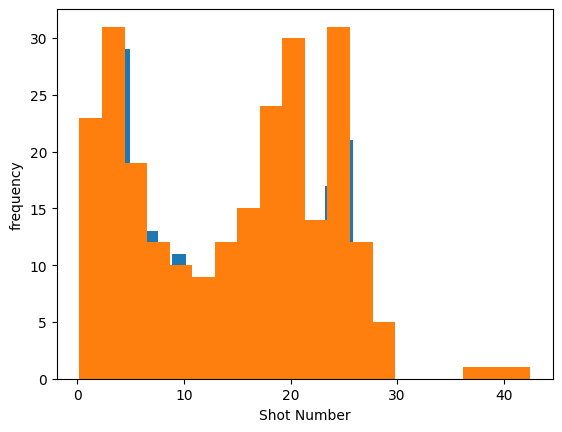

In [7]:
# Exploratory Data Analysis
plt.hist(base['SHOT_DIST'],bins=20)
plt.hist(hot['SHOT_DIST'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

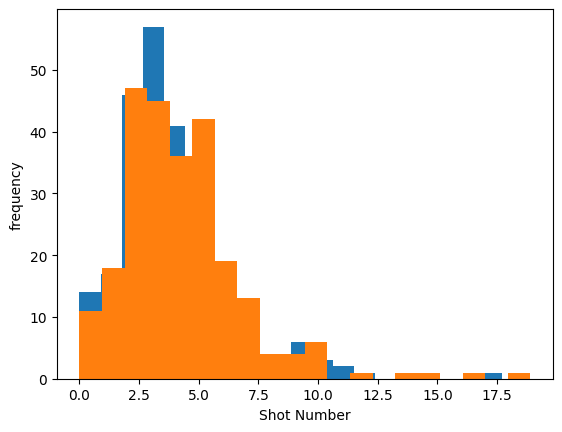

In [8]:
# Exploratory Data Analysis
plt.hist(base['CLOSE_DEF_DIST'],bins=20)
plt.hist(hot['CLOSE_DEF_DIST'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

In [9]:
samp.describe()

LOCATION  SHOT_NUMBER      PERIOD  GAME_CLOCK_DECIMAL  SHOT_CLOCK  \
count  500.000000   500.000000  500.000000          500.000000  500.000000   
mean     0.580000    10.268000    2.502000            4.799333   12.025933   
std      0.494053     5.896925    1.122727            3.249835    6.103627   
min      0.000000     1.000000    1.000000            0.000000    0.000000   
25%      0.000000     5.750000    1.000000            1.979167    7.575000   
50%      1.000000     9.000000    3.000000            4.525000   12.000000   
75%      1.000000    14.000000    3.000000            7.133333   16.825000   
max      1.000000    33.000000    5.000000           11.833333   24.000000   

         DRIBBLES   SHOT_DIST    PTS_TYPE  DEFENDER_HEIGHT_CM  \
count  500.000000  500.000000  500.000000          500.000000   
mean     3.218000   13.819600    2.230000          201.972400   
std      4.689398    8.814977    0.421254            8.884536   
min      0.000000    0.200000    2.000000          175.260000   
25%      0.000000    4.875000    2.000000          195.580000   
50%      2.000000   15.000000    2.000000          203.200000   
75%      4.000000   21.200000    2.000000          208.280000   
max     24.000000   42.500000    3.000000          218.440000   

       DEFENDER_WEIGHT_KG  CLOSE_DEF_DIST         FGM  PLAYER_HEIGHT  \
count          500.000000      500.000000  500.000000     500.000000   
mean           102.434042        4.101600    0.508000     200.126600   
std             11.705415        2.525517    0.500437       8.744983   
min             76.203456        0.000000    0.000000     182.880000   
25%             92.986360        2.575000    0.000000     190.500000   
50%            102.058200        3.500000    1.000000     200.660000   
75%            111.130040        5.225000    1.000000     208.280000   
max            131.541680       18.900000    1.000000     213.360000   

       PLAYER_WEIGHT  HOT_HAND_SHOT_STREAK2  HOT_HAND_SHOT_STREAK3  \
count     500.000000             500.000000             500.000000   
mean      100.436155               0.552000               0.500000   
std        12.046081               0.497787               0.500501   
min        79.378600               0.000000               0.000000   
25%        87.543256               0.000000               0.000000   
50%        99.790240               1.000000               0.500000   
75%       113.398000               1.000000               1.000000   
max       117.933920               1.000000               1.000000   

       GAME_TIME_ELAPSED     num_HHS  num_not_HHS  
count         500.000000  500.000000   500.000000  
mean           25.196667   67.430000   865.404000  
std            13.991615   10.959988    87.173018  
min             0.233333   54.000000   653.000000  
25%            11.979167   58.000000   821.000000  
50%            24.858333   64.000000   888.000000  
75%            35.862500   72.000000   907.000000  
max            50.683333   96.000000   990.000000

In [10]:
def predictor_matrix(data: pd.DataFrame, col_names: list, adjust_std=False) -> np.array:
    """
    given a dataframe  and list  containing p column names,
    return a numpy (N x p+1) matrix X with N observations and p
    standardized predictors (first column is the intercept column full of ones)
    if  == True, then use n-1 as divisor for std rather than n when
    standardizing predictors
    """
    predictors = data[col_names].to_numpy()
    normd_predictors = (predictors - np.mean(predictors, axis=0, keepdims=True)) / np.std(predictors, axis=0, keepdims=True, ddof=adjust_std)
    return np.insert(normd_predictors, 0, 1, axis=1)


In [11]:
# model 1
# list of column names you want to keep to use as predictors:
col_names1 = ['LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_DECIMAL',
            'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
             'DEFENDER_WEIGHT_KG', 'CLOSE_DEF_DIST', 'PLAYER_HEIGHT',
             'PLAYER_WEIGHT', 'HOT_HAND_SHOT_STREAK3']
X1 = predictor_matrix(samp, col_names1)
P1 = X1.shape[1] - 1

#Look into colinearity, and exclude some with high colinearity

In [12]:
# model 2

col_names2 = ['LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'CLOSE_DEF_DIST','PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']
X2 = predictor_matrix(samp, col_names2)
P2 = X2.shape[1] - 1

In [16]:
y2 = np.zeros((2*N,1))
y2[:,0] = samp['FGM']

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.DataFrame(X1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ['FGM','LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_DECIMAL',
            'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
             'DEFENDER_WEIGHT_KG', 'CLOSE_DEF_DIST', 'PLAYER_HEIGHT',
             'PLAYER_WEIGHT', 'HOT_HAND_SHOT_STREAK3']

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

#anything above 5 is high multicolinearity

                  feature       VIF
0                     FGM  1.000000
1                LOCATION  1.016163
2             SHOT_NUMBER  4.081128
3                  PERIOD  3.760839
4      GAME_CLOCK_DECIMAL  1.431186
5              SHOT_CLOCK  1.242037
6                DRIBBLES  1.472780
7               SHOT_DIST  1.475804
8      DEFENDER_HEIGHT_CM  3.416545
9      DEFENDER_WEIGHT_KG  3.484530
10         CLOSE_DEF_DIST  1.258158
11          PLAYER_HEIGHT  7.704312
12          PLAYER_WEIGHT  6.803212
13  HOT_HAND_SHOT_STREAK3  1.129418


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.DataFrame(X2)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = ['FGM','LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
               'CLOSE_DEF_DIST', 'PLAYER_HEIGHT', 'HOT_HAND_SHOT_STREAK3']

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

#anything above 5 is high multicolinearity

                 feature       VIF
0                    FGM  1.000000
1               LOCATION  1.010838
2             SHOT_CLOCK  1.102264
3              SHOT_DIST  1.401935
4     DEFENDER_HEIGHT_CM  1.175083
5         CLOSE_DEF_DIST  1.238170
6          PLAYER_HEIGHT  1.220085
7  HOT_HAND_SHOT_STREAK3  1.027967


In [18]:
# Import the 'pymc' library as 'pm' for probabilistic modeling and Bayesian inference.
import pymc as pm
# Import the 'numpy' library as 'np' for numerical operations such as creating arrays and mathematical functions.
import numpy as np

# Begin defining a new model context named 'MLR'.
with pm.Model() as MLR:
    # Define a multivariate normal (MvNormal) distribution for the regression coefficients ('betas').
    # 'mu' specifies the mean of the distribution, set to a zero vector of size P2+1 to indicate no prior bias.
    # 'cov' specifies the covariance matrix, set to an identity matrix of size P2+1, assuming independence and identical variance.
    # 'shape' specifies the shape of the variable, here a vector of size P2+1, where P2 is presumably the number of predictors.
    betas = pm.MvNormal('betas', mu=np.zeros((P2+1,1)), cov=np.eye(P2+1), shape=(P2+1,))

    # Define a Bernoulli distribution for the dependent variable 'y'.
    # 'logit_p' specifies the logit of the probability of success, calculated as the dot product of predictors 'X2' and coefficients 'betas'.
    # 'observed' is set to 'y2', indicating that 'y' is an observed variable in the data.
    y = pm.Bernoulli('y', logit_p=pm.math.dot(X2, betas), observed=y2)

# Within the context of the model 'MLR', sample from the posterior distribution using MCMC methods.
with MLR:
    idata = pm.sample()



HMC Split-Rhats {'betas': array([[1.00637836, 1.00075925, 1.00036459, 1.00257004, 0.99938353,
        1.00002688, 1.0007825 , 1.00020579],
       [0.99959098, 1.00076812, 0.99995578, 0.99929188, 1.00060985,
        1.00327175, 1.00092515, 0.99968574],
       [1.00053493, 1.00061046, 1.00578671, 1.00201524, 1.00056675,
        1.00181392, 0.99932369, 0.99981812],
       [1.00003611, 0.99993533, 0.99996069, 0.99973955, 1.00085739,
        1.00176707, 1.00146938, 0.99967703],
       [0.99939361, 0.99942119, 0.99977862, 1.00291712, 1.00104013,
        0.9997955 , 0.99913812, 0.99958885],
       [1.00020721, 1.00065506, 1.000314  , 0.99992856, 1.00111972,
        1.00032521, 1.00017336, 0.99995481],
       [1.00065   , 1.00264878, 0.99987484, 1.00078729, 1.00371505,
        1.00131982, 1.00262416, 1.00064654],
       [1.00007388, 0.99943263, 1.00142442, 0.99955896, 1.00051533,
        1.00009825, 0.99944395, 1.00167343]])} | 

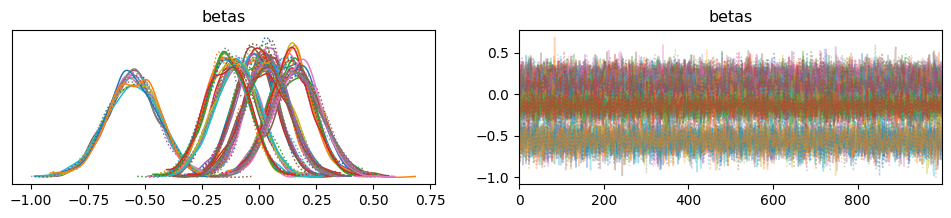

In [ ]:
# Import the 'arviz' library as 'az' for exploratory analysis of Bayesian models, including diagnostics and visualizations.
import arviz as az
# Import the 'matplotlib.pyplot' module as 'plt' for creating static, interactive, and animated visualizations in Python.
import matplotlib.pyplot as plt

# Use the 'plot_trace' function from ArviZ to generate trace plots of the sampled parameters.
# Trace plots are useful for assessing the mixing and convergence of the MCMC chains.
# 'idata' is assumed to be the InferenceData object containing the results of the model sampling.
az.plot_trace(idata);

# Compute the R-hat statistic for each variable in the model using ArviZ's 'rhat' function.
# R-hat is a convergence diagnostic that compares the variance within chains to the variance between chains.
# Values close to 1 indicate convergence, while values above 1.1 suggest lack of convergence.
# Here, 'rhat' values are rounded to 'P2+1' decimal places for concise display, where 'P2' is defined elsewhere in your code.
# The resulting R-hat values for each variable are printed with the label "HMC Split-Rhats".
print("HMC Split-Rhats", {k: np.round(v.values, P2+1) for k, v in az.rhat(idata).items()}, end=' | ')
# The comment at the end notes that all split R-hat values are below 1.05, indicating no signs of divergence or lack of convergence.
# This is an important quality check for ensuring the reliability of the model's posterior estimates.


In [ ]:
# Import necessary libraries and functions: PyMC for probabilistic modeling, numpy for numerical operations,
# and invlogit for the logistic function, supporting logistic regression modeling.
import pymc as pm
import numpy as np
from pymc.math import invlogit as tt_invlogit

# Start defining a new probabilistic model named 'MLR'.
with pm.Model() as MLR:
    # Define an LKJ Cholesky covariance matrix, a method for specifying a prior over covariance matrices in a way that
    # is computationally efficient and ensures positive definiteness. It's particularly useful for multivariate normal distributions.
    packed_L = pm.LKJCholeskyCov("packed_L", n=P2+1, eta=2.0, sd_dist=pm.HalfCauchy.dist(beta=10, shape=P2+1), compute_corr=False)
    L = pm.expand_packed_triangular(P2+1, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))  # Calculate the covariance matrix Sigma from L.

    # Implement the horseshoe prior for regularization, helping in identifying truly relevant predictors among potentially many covariates.
    tau_0 = 0.03
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)  # Global shrinkage parameter.
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(P2+1))  # Local shrinkage parameters.
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2+1))  # Weights for the predictors.

    # Define the multivariate normal distribution for regression coefficients ('betas'), with a mean vector of zeros
    # and the covariance matrix 'Sigma' determined above.
    betas = pm.MvNormal('betas', mu=np.zeros((P2+1,1)), cov=Sigma, shape=(P2+1))

    # Define the observed variable 'y', modeled as a Bernoulli distribution with the logit of the probability
    # determined by the dot product of the predictors 'X2' and the product of 'betas' and 'weights'.
    y = pm.Bernoulli('y', logit_p=pm.math.dot(X2, betas*weights), observed=y2)

# In the model context 'MLR', set up and perform sampling using the Metropolis-Hastings algorithm, a specific MCMC method.
with MLR:
    MH = pm.Metropolis([betas], S=np.array([0.1]), tune=False, tune_interval=0)  # Configure the Metropolis-Hastings sampler.
    idata_MH = pm.sample(step=MH)  # Execute sampling.

    #for proj we can make note on how long it takes computationally to use chol
    #problem in mixing?
    #invalid value could be near 0 value in log

/usr/local/lib/python3.10/dist-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


HMC Split-Rhats {'weights': array([2.03823535, 2.15528594, 1.05817099, 1.19093633, 1.90946908,
       2.2693152 , 1.9610124 , 2.05350687]), 'betas': array([[1.43371945, 1.05655405, 1.02255618, 1.05704762, 1.09742283,
        1.05291134, 1.08143546, 1.20885125],
       [1.3772116 , 1.1051261 , 1.02890941, 1.03430222, 1.08227065,
        1.14051122, 1.06375548, 1.1502172 ],
       [1.75635832, 1.8136107 , 1.0470539 , 1.08560142, 1.77304595,
        1.91442643, 1.81523404, 1.67669868],
       [2.08685857, 2.27118382, 1.06225893, 1.27145227, 2.06714437,
        2.56105241, 1.89392563, 2.08998025],
       [1.61500968, 1.65246778, 1.03516802, 1.05651386, 1.63913442,
        1.92172287, 1.51705121, 1.72036222],
       [1.57588572, 1.6444916 , 1.03773372, 1.11528749, 1.76809307,
        1.8009697 , 1.74410468, 1.59969478],
       [1.43291889, 1.13301711, 1.03685956, 1.04247251, 1.11822977,
        1.15297823, 1.17304428, 1.19632429],
       [1.78163119, 2.01783261, 1.03105996, 1.12172919, 1.93

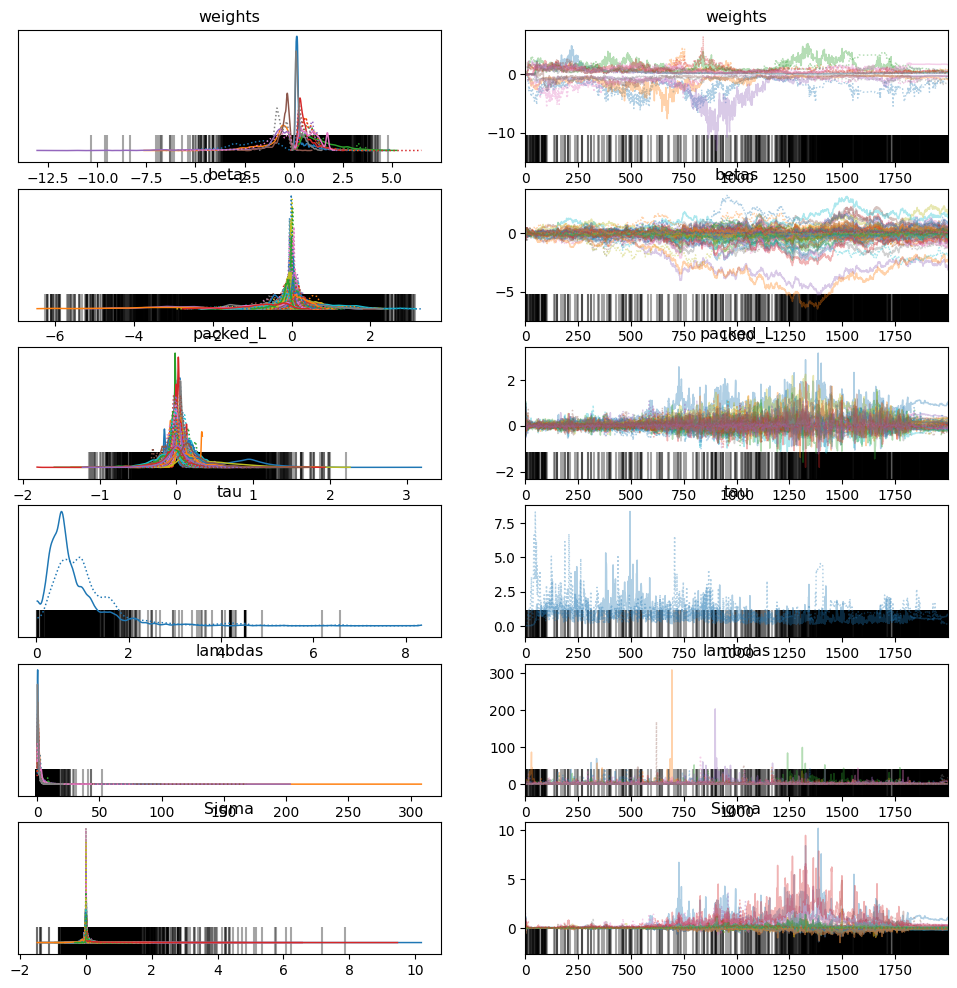

In [ ]:
# Import the 'arviz' library as 'az' for Bayesian analysis visualization and diagnostics.
import arviz as az
# Import the 'matplotlib.pyplot' module as 'plt' for plotting capabilities.
import matplotlib.pyplot as plt

# Generate trace plots for the parameters of the model 'idata_MH' using ArviZ's 'plot_trace' function.
# Trace plots visually represent the sampling paths of the MCMC chains for each parameter, providing insight into
# their convergence behavior and distribution. This is crucial for assessing the quality of the Bayesian inference.
az.plot_trace(idata_MH);

# Compute the R-hat statistics for each parameter in the model 'idata_MH' and print them.
# The R-hat statistic is a measure of convergence for MCMC simulations. It compares the variance within chains
# to the variance between chains. Values close to 1 indicate that chains are well mixed and sampling from the
# posterior distribution is likely to be reliable. Here, R-hat values are rounded to 'P2+1' decimal places for readability.
# The resulting R-hat values for each variable are then printed, with an additional note stating that all R-hat
# values are below 1.05, indicating good convergence without signs of divergence.
# This is a critical step in model validation, ensuring that the posterior distributions are stable and reflective of the data.
print("HMC Split-Rhats", {k: np.round(v.values, P2+1) for k, v in az.rhat(idata_MH).items()}, end=' | ')


In [19]:
#MODEL 3
# Import the necessary libraries: PyMC for Bayesian modeling, numpy for numerical operations,
# and a specific function from PyMC for the logistic function.
import pymc as pm
import numpy as np
from pymc.math import invlogit as tt_invlogit

# Begin defining a new Bayesian model named 'MLR' for logistic regression.
with pm.Model() as MLR:
    # Set up the horseshoe prior for regularization, aiming to identify significant predictors.
    # The horseshoe prior is a robust regularization method that can effectively handle cases with many predictors,
    # distinguishing between relevant and irrelevant ones by shrinking the latter towards zero.
    tau_0 = 1  # The global scale parameter for the horseshoe prior, controlling overall shrinkage.
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)  # Global shrinkage parameter with a Half-Cauchy distribution.
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(P2+1))  # Local shrinkage parameters for each predictor.
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2+1))  # Weights for predictors, modulated by the horseshoe prior.
    betas = pm.MvNormal('betas', mu=np.zeros((P2+1,1)), cov=np.eye(P2+1), shape=(P2+1))  # Regression coefficients with a multivariate normal prior.

    # Define the likelihood of the observed data 'y', assuming a Bernoulli distribution.
    # The logit of the success probability is given by the dot product of predictors 'X2' and the product of 'betas' and 'weights'.
    y = pm.Bernoulli('y', logit_p=pm.math.dot(X2, betas*weights), observed=y2)

# Within the defined model 'MLR', perform sampling to infer the posterior distributions of the model parameters.
with MLR:
    idata = pm.sample()

    # Placeholder comments for addressing potential issues and observations regarding the model:
    # "misspecified horseshoe bc not shrinking to 0" suggests a concern that the horseshoe prior may not be effectively
    # shrinking irrelevant predictors towards zero as intended, which could indicate a misapplication or misconfiguration of the prior.
    # "regularized horseshoe, seeing something interesting with bi-modal, report on" hints at observing bi-modal distributions in the posterior,
    # which could be noteworthy, particularly if the model is expected to identify distinct groups or effects in the data. This could merit further investigation and reporting.


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


HMC Split-Rhats {'weights': array([1.82956645, 1.00103544, 1.84072916, 1.83017601, 1.83564442,
       1.00025873, 1.00215403, 1.83064048]), 'betas': array([[1.05516352, 1.00125319, 1.05849083, 1.06069676, 1.06915858,
        1.00310613, 0.99953539, 1.05978979],
       [1.0133713 , 1.00252652, 1.01875925, 1.01063293, 1.01250696,
        1.00102058, 1.00428591, 1.01199462],
       [1.75717423, 1.00256027, 1.74419782, 1.73251092, 1.74814934,
        1.00180881, 1.00095566, 1.7260951 ],
       [1.82771866, 1.00011304, 1.83181686, 1.82688501, 1.8331443 ,
        1.00171845, 0.9995743 , 1.8273633 ],
       [1.21643951, 1.00105964, 1.2172085 , 1.22222425, 1.21507362,
        0.99998787, 0.99982383, 1.20644593],
       [1.34547126, 1.00052388, 1.40615644, 1.33494497, 1.28751812,
        0.99963941, 1.00130781, 1.33208245],
       [1.13640701, 1.0020919 , 1.12808865, 1.15301182, 1.14070042,
        1.00084069, 1.00255745, 1.14086038],
       [1.69856343, 0.99934216, 1.65860652, 1.68877918, 1.66

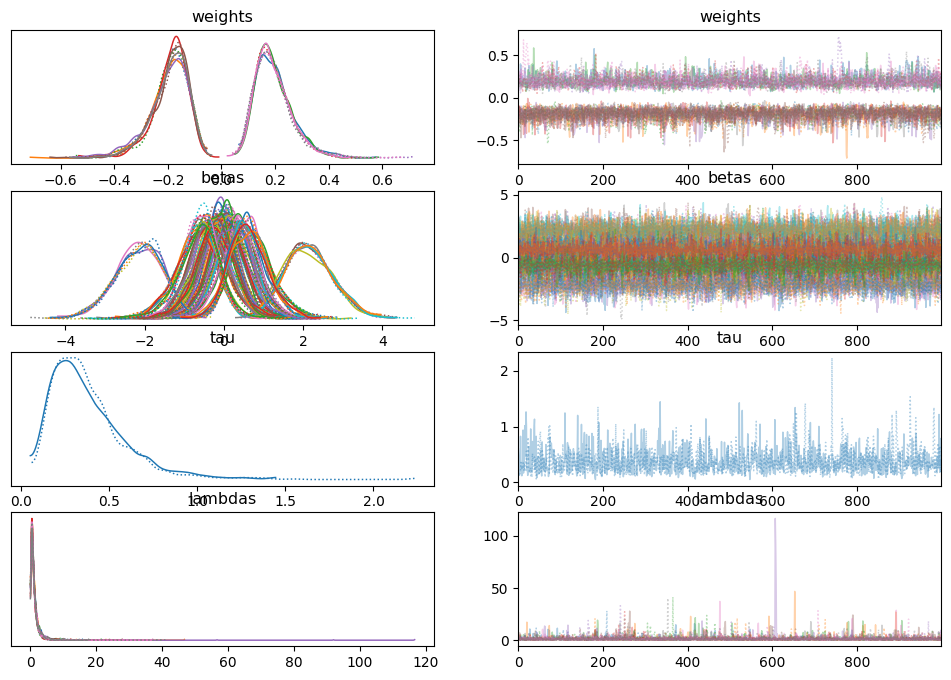

In [20]:
# Import ArviZ for Bayesian model diagnostics and visualizations.
import arviz as az
# Import Matplotlib's pyplot for custom plotting.
import matplotlib.pyplot as plt

# Use ArviZ's plot_trace function to generate trace plots for the model parameters contained in 'idata'.
# Trace plots display the Markov Chain Monte Carlo (MCMC) sampling paths for each parameter, helping to assess
# convergence and the posterior distribution's shape. It's a key diagnostic tool in Bayesian inference.
az.plot_trace(idata);

# Calculate and print the R-hat statistic for each parameter using ArviZ's rhat function.
# The R-hat statistic compares the variance of chain averages with the variance of the pooled samples
# across all chains. Values close to 1 indicate that chains have likely converged to the stationary distribution.
# Here, R-hat values are rounded to 'P2+1' decimal places for each parameter, enhancing readability.
# The output is structured to ensure that all R-hat values are followed by a '|', aiding in quick visual inspection.
print("HMC Split-Rhats", {k: np.round(v.values, P2+1) for k, v in az.rhat(idata).items()}, end=' | ')

# The final comment reflects a conclusion from the R-hat values analysis: if no R-hat is greater than 1.05,
# it suggests that the model parameters have converged well across multiple chains, with no evidence of divergence.
# This is a positive signal about the quality and reliability of the MCMC sampling process.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
weights[0]   0.001  0.213  -0.323    0.336      0.142    0.117       3.0   
weights[1]  -0.001  0.206  -0.310    0.314      0.138    0.114       3.0   
weights[2]   0.200  0.086   0.071    0.342      0.004    0.003     653.0   
weights[3]  -0.002  0.216  -0.317    0.323      0.143    0.118       3.0   
weights[4]  -0.036  0.206  -0.313    0.321      0.120    0.095       4.0   
...            ...    ...     ...      ...        ...      ...       ...   
betas[7, 3]  0.004  0.794  -1.451    1.368      0.458    0.362       3.0   
betas[7, 4]  0.132  0.775  -1.491    1.320      0.392    0.301       4.0   
betas[7, 5] -0.623  0.474  -1.504    0.293      0.009    0.009    2726.0   
betas[7, 6] -0.004  0.771  -1.312    1.484      0.442    0.349       3.0   
betas[7, 7]  0.614  0.512  -0.375    1.575      0.011    0.009    2404.0   

             ess_tail  r_hat  
weights[0]       98.0   1.83  
weights[1]       79.0   1

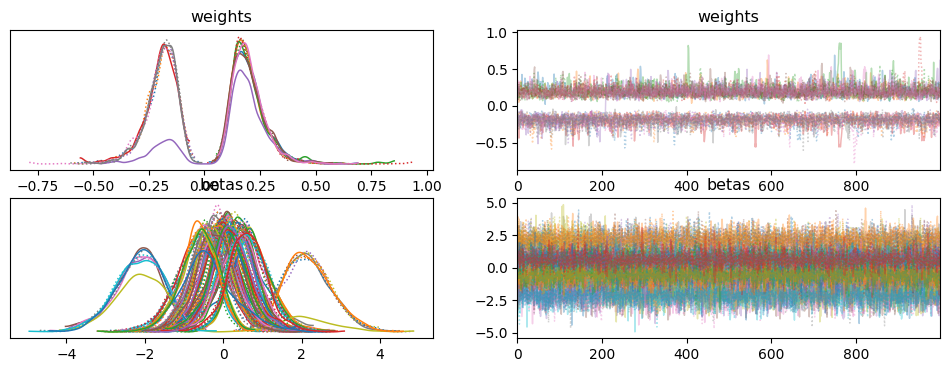

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (72) in plot_posterior, generating only 40 plots
  warnings.warn(


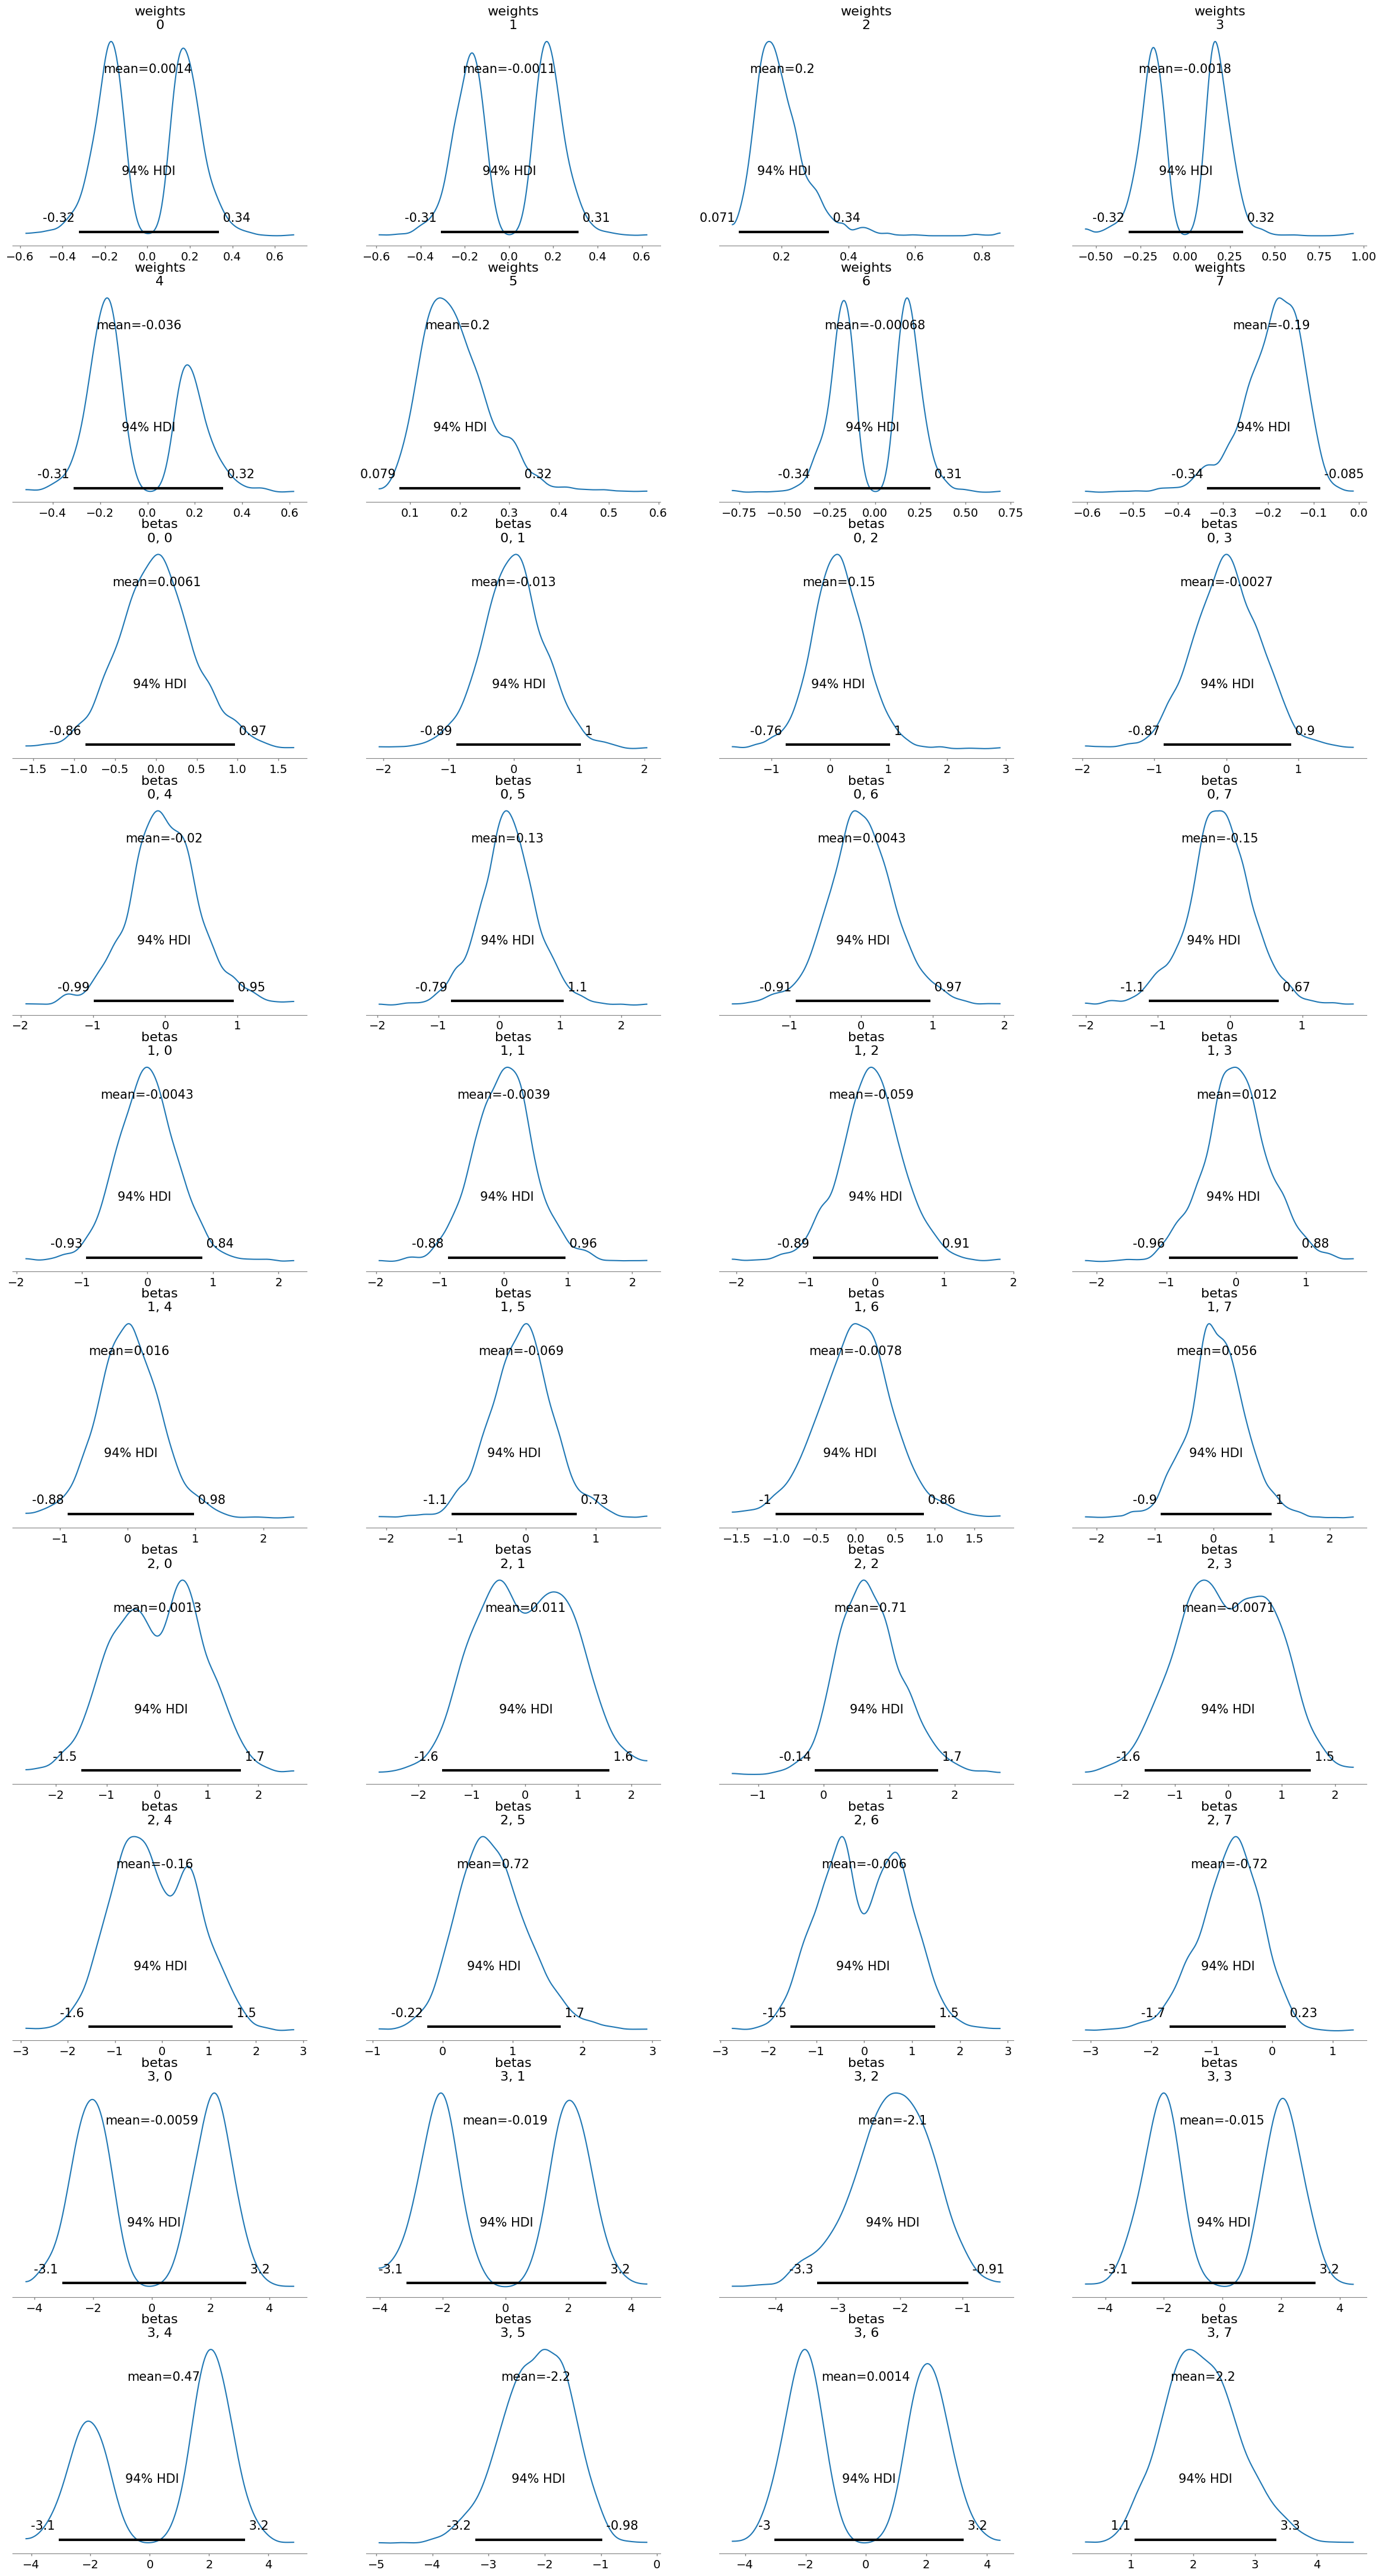

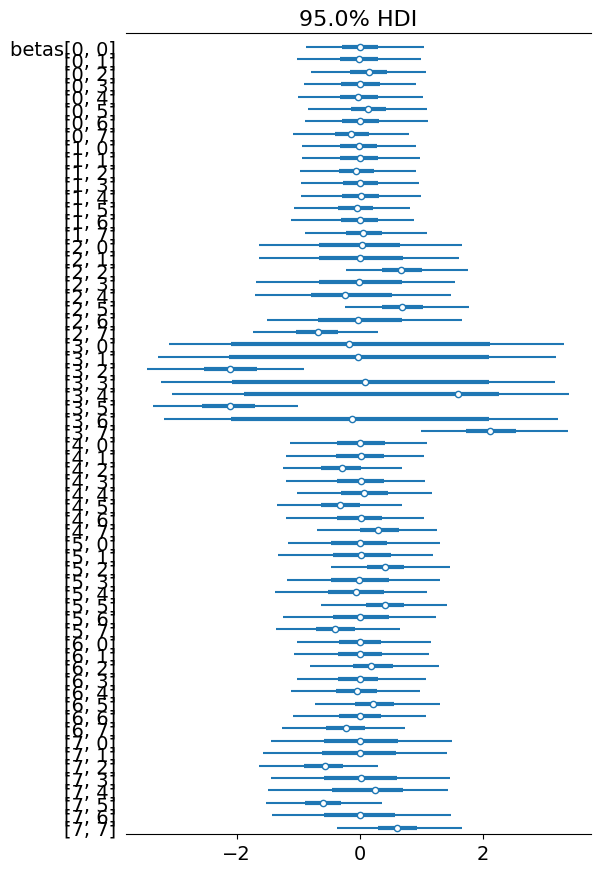

/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


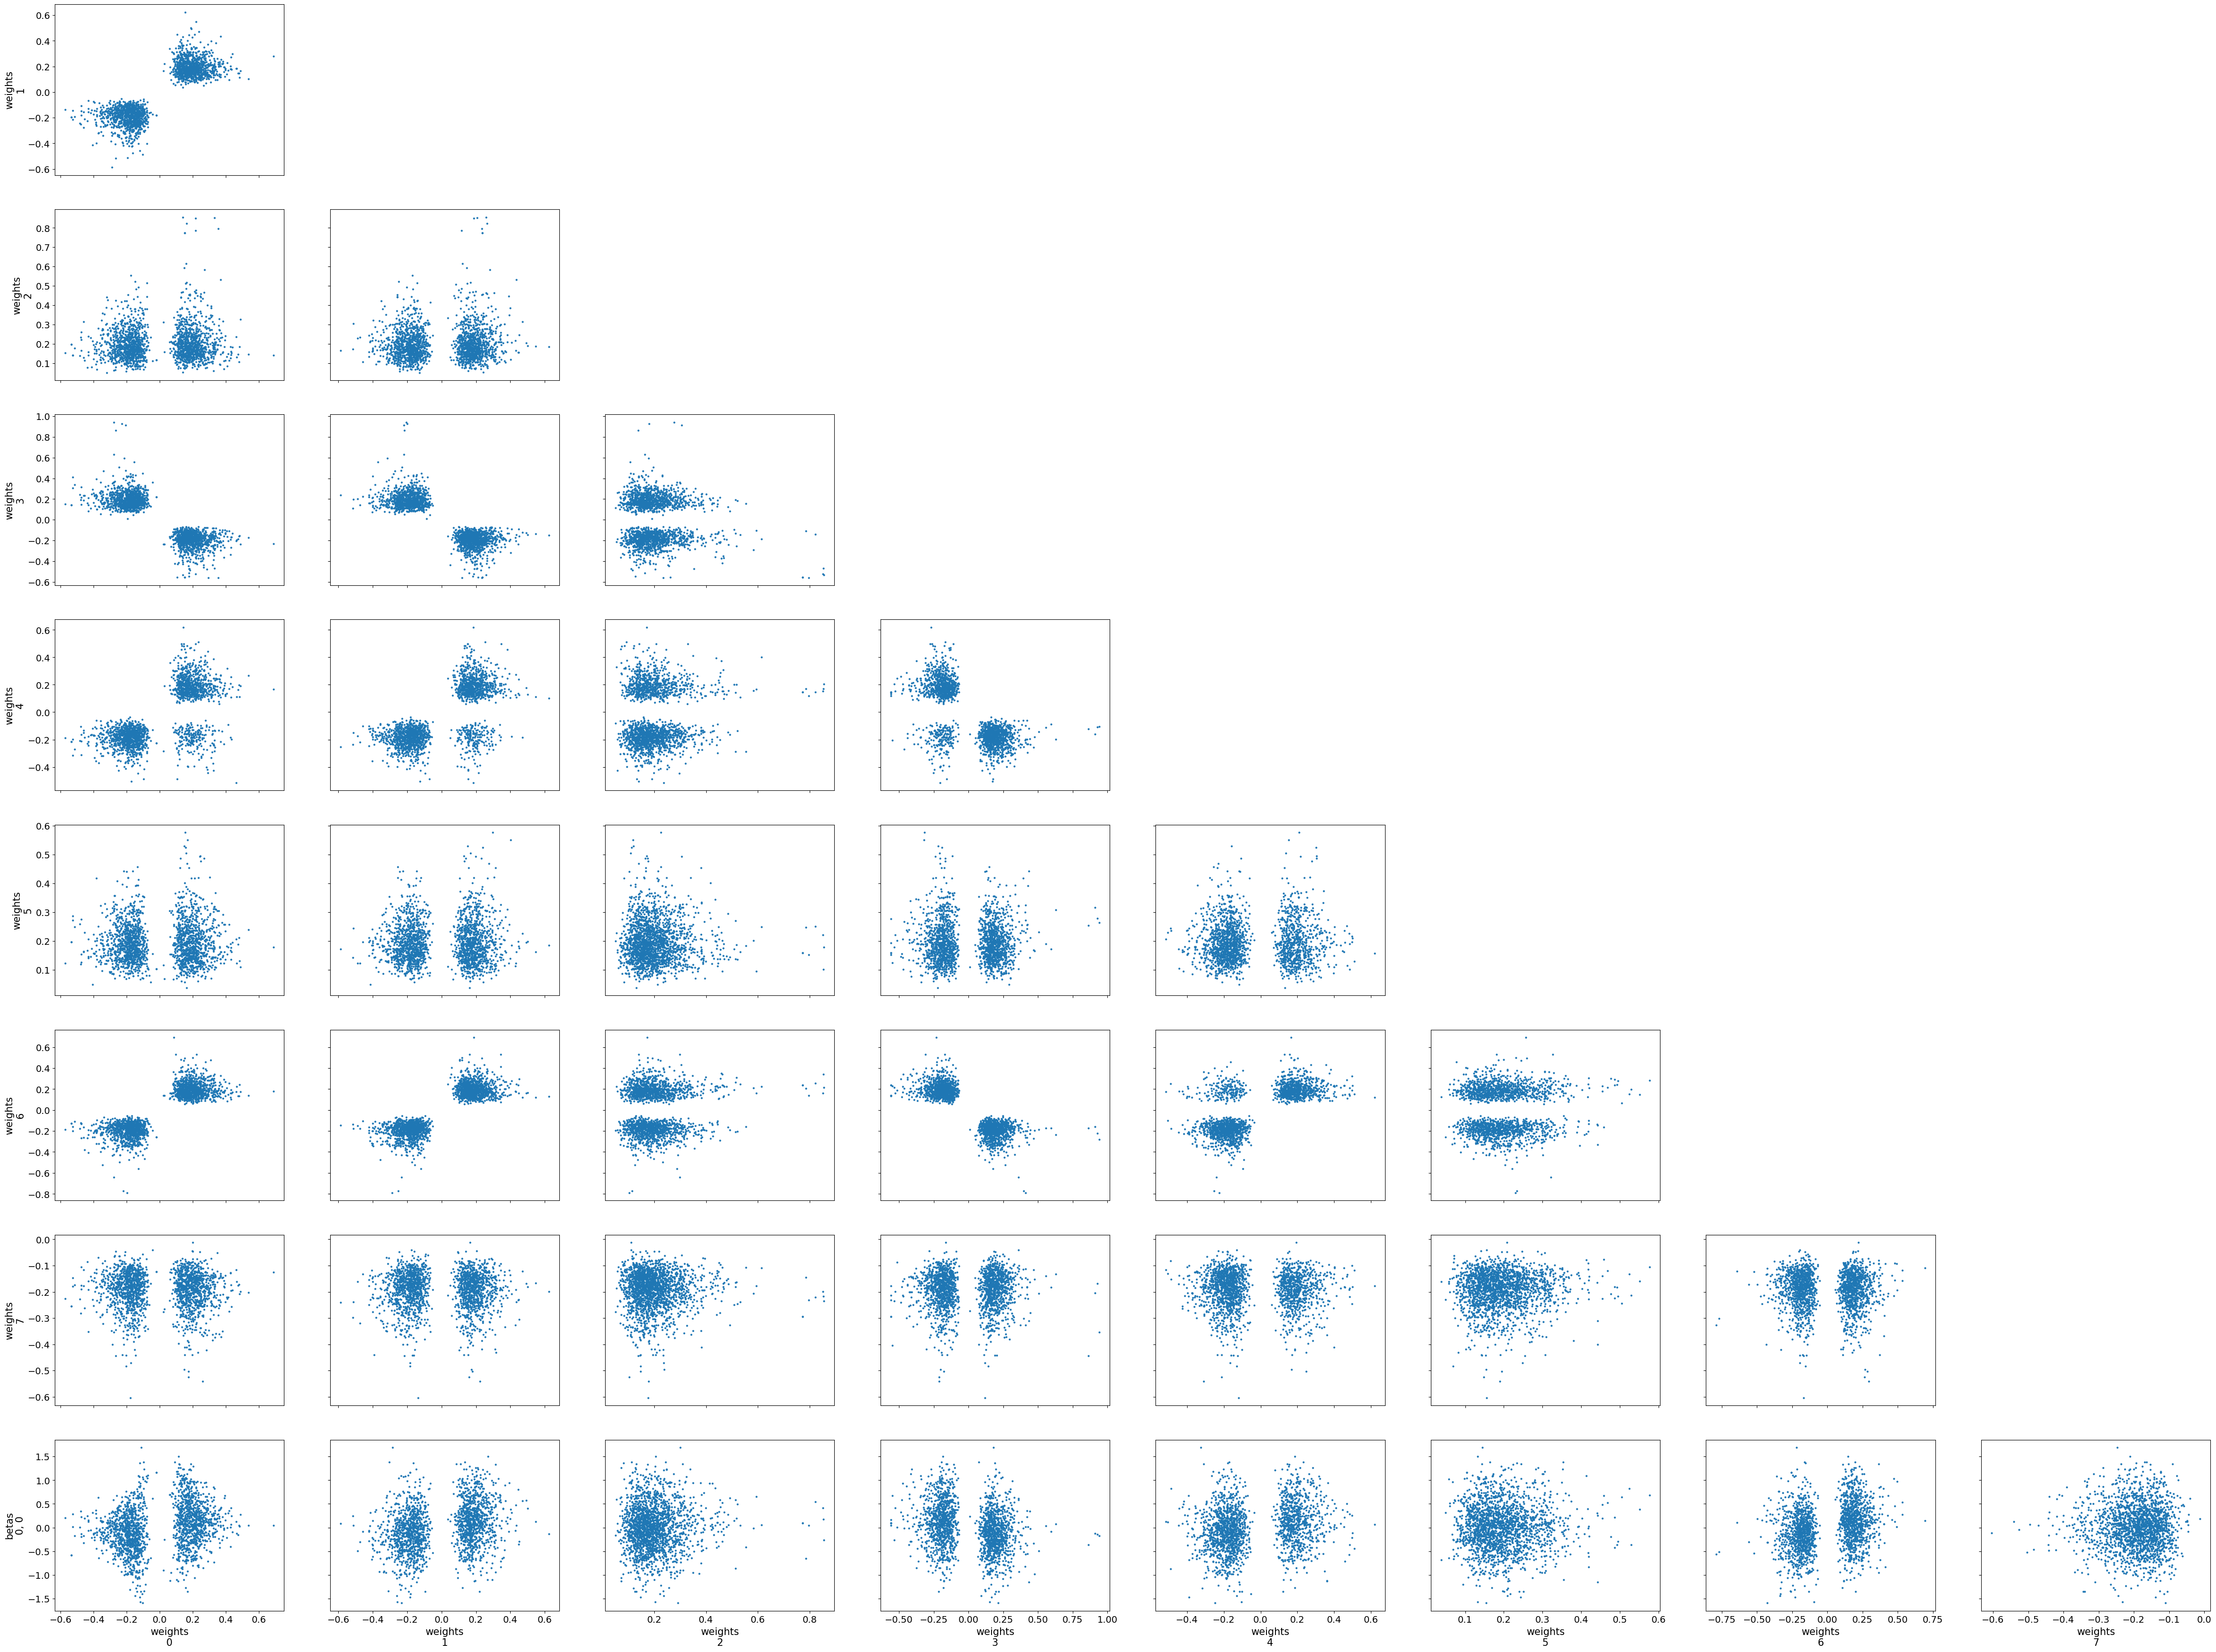

In [ ]:

# Analysis and Visualization
# Summary statistics
summary = az.summary(idata, var_names=['weights', 'betas'])
print(summary)

# Trace plot
az.plot_trace(idata, var_names=['weights', 'betas'])
plt.show()

# Posterior plot
az.plot_posterior(idata, var_names=['weights', 'betas'])
plt.show()

# Forest plot for betas
az.plot_forest(idata, var_names=['betas'], combined=True, hdi_prob=0.95)
plt.show()

# Pair plot for exploring relationships between parameters
az.plot_pair(idata, var_names=['weights', 'betas'])
plt.show()


In [21]:
#model 4
P2 = X2.shape[1]
with pm.Model() as model:
    # Spike-Slab components for the HOT_HAND_SHOT_STREAK3 coefficient
    inclusion_prob = pm.Beta('inclusion_prob', alpha=1, beta=1)
    slab = pm.Normal('slab', mu=0, sigma=10)

    # Binary variable to choose between spike (effect = 0) and slab
    include_effect = pm.Bernoulli('include_effect', p=inclusion_prob)

    # Coefficient for HOT_HAND_SHOT_STREAK3
    beta_hot_hand = pm.math.switch(include_effect, slab, 0)

    # Coefficients for other predictors
    betas_other = pm.Normal('betas_other', mu=0, sigma=1, shape=(P2-1,))

    # Combine all coefficients, assuming HOT_HAND_SHOT_STREAK3 is the last predictor in X2
    # Adjust the concatenation logic if HOT_HAND_SHOT_STREAK3 is in a different position
    betas = pm.math.concatenate([betas_other, [beta_hot_hand]])

    # Calculate the probability of a shot being made
    p_shot_made = pm.math.sigmoid(pm.math.dot(X2, betas))

    # Likelihood of observing the data
    y = pm.Bernoulli('y', p=p_shot_made, observed=y2.flatten())
with MLR:
    idata = pm.sample()


In [32]:
print(ppc.keys())  # This should show you the structure, e.g., dict_keys(['y'])


KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


TypeError: `group` argument must be either `posterior` or `prior`

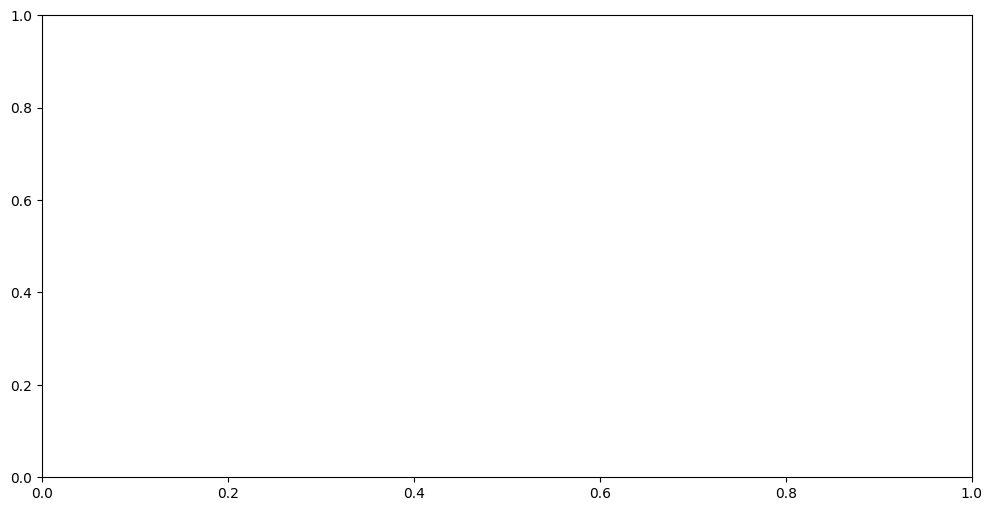

In [31]:
import arviz as az
import matplotlib.pyplot as plt

# Assuming 'idata' is your InferenceData object and 'ppc' is the posterior predictive samples dictionary

# If your 'ppc' samples aren't already part of 'idata', add them manually.
# This step is conditional based on how 'idata' and 'ppc' are structured.
if 'posterior_predictive' not in idata.groups():
    idata.add_group('posterior_predictive', ppc)

# Now, you can attempt plotting PPC with the updated 'idata'.
_, ax = plt.subplots(figsize=(12, 6))
az.plot_ppc(idata, group='posterior_predictive', kind='cumulative', ax=ax)
plt.title("Posterior Predictive Check")
plt.show()




# Summary statistics for the posterior distributions
summary_stats = az.summary(idata)
print(summary_stats)

# Autocorrelation plot for each parameter
az.plot_autocorr(idata)
plt.show()

# Extract the mean posterior predictive values from 'ppc'

correct_key = 'y'  # Replace 'y' with the actual key if different
y_pred = ppc[correct_key].mean(axis=0)


# Compare observed and predicted values
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(y2.flatten(), 'o', label='Observed', alpha=0.5)
ax.plot(y_pred, 'o', label='Predicted', alpha=0.5)
ax.set(title="Observed vs. Predicted", xlabel="Sample Index", ylabel="Outcome")
plt.legend()
plt.show()

# Effective sample sizes
ess = az.ess(idata)
print("Effective Sample Sizes:\n", ess)

# Check for divergences
divergences = az.plot_pair(idata, kind='scatter', divergences=True)
plt.title("Divergence Check")
plt.show()



In [ ]:
#model 5

P2 = X2.shape[1]

with pm.Model() as model:
    # Spike-Slab components for the HOT_HAND_SHOT_STREAK3 coefficient
    inclusion_prob = pm.Beta('inclusion_prob', alpha=1, beta=1)
    slab = pm.Normal('slab', mu=0, sigma=10)

    # Binary variable to choose between spike (effect = 0) and slab
    include_effect = pm.Bernoulli('include_effect', p=inclusion_prob)

    # Coefficient for HOT_HAND_SHOT_STREAK3
    # beta_hot_hand = pm.math.switch(include_effect, slab, 0)
    beta_hot_hand = pm.Deterministic("beta_hot_hand", include_effect*slab)


    #Horsehoe prior to help distinguish useful predictors
    tau_0 = 0.01;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(P2-1));
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2-1))
    # Coefficients for other predictors, using horsehoe
    betas_other = pm.Normal('betas_other', mu=0, sigma=1, shape=(P2-1,))

    # Combine all coefficients, assuming HOT_HAND_SHOT_STREAK3 is the last predictor in X2
    # Adjust the concatenation logic if HOT_HAND_SHOT_STREAK3 is in a different position
    betas = pm.math.concatenate([betas_other*weights, [beta_hot_hand]])

    # Calculate the probability of a shot being made
    p_shot_made = pm.math.sigmoid(pm.math.dot(X2, betas))

    # Likelihood of observing the data
    y = pm.Bernoulli('y', p=p_shot_made, observed=y2.flatten())
with model:
    idata = pm.sample()


HMC Split-Rhats {'slab': 1.009405986, 'include_effect': 1.01261327, 'weights': array([1.01367085, 1.01867162, 1.00557015, 1.01738281, 1.00555008,
       1.0030089 , 1.02266847]), 'betas_other': array([1.00418199, 1.03505324, 1.01079646, 1.01269457, 1.00713468,
       1.01342751, 1.00685576]), 'inclusion_prob': 1.019580019, 'tau': array([1.00553598]), 'lambdas': array([1.02005468, 1.01406357, 1.00866536, 1.00668921, 1.00065119,
       1.01810442, 1.01523819]), 'beta_hot_hand': 1.012696337} | 

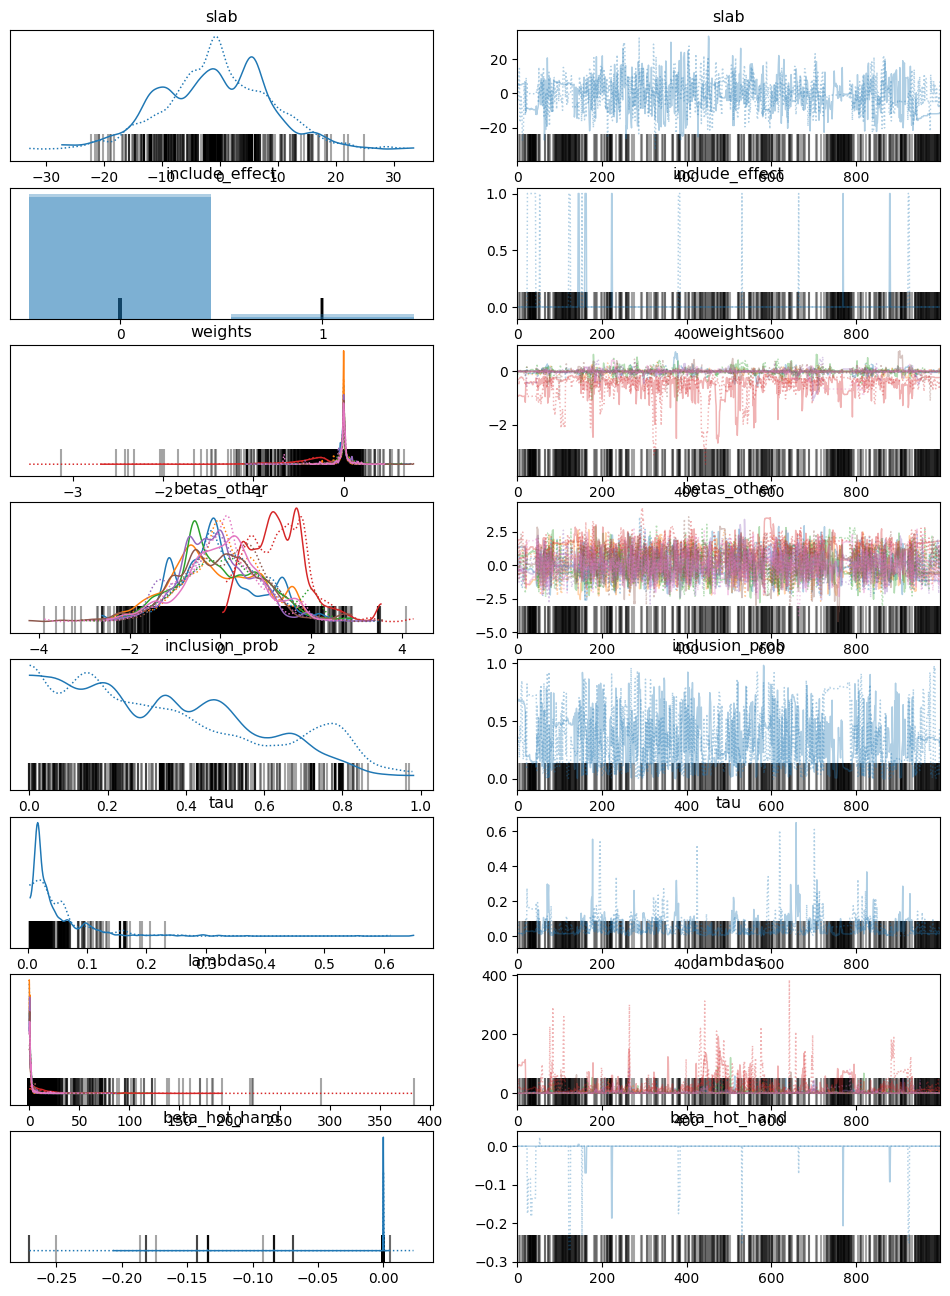

In [ ]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata);
print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

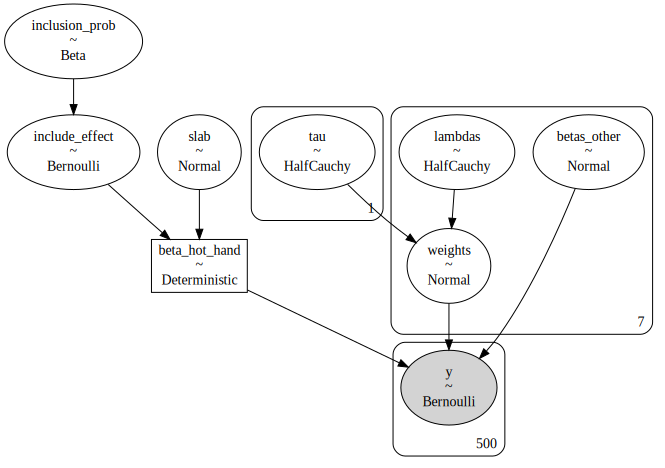

In [ ]:
# Visualization of model graph
pm.model_to_graphviz(model)

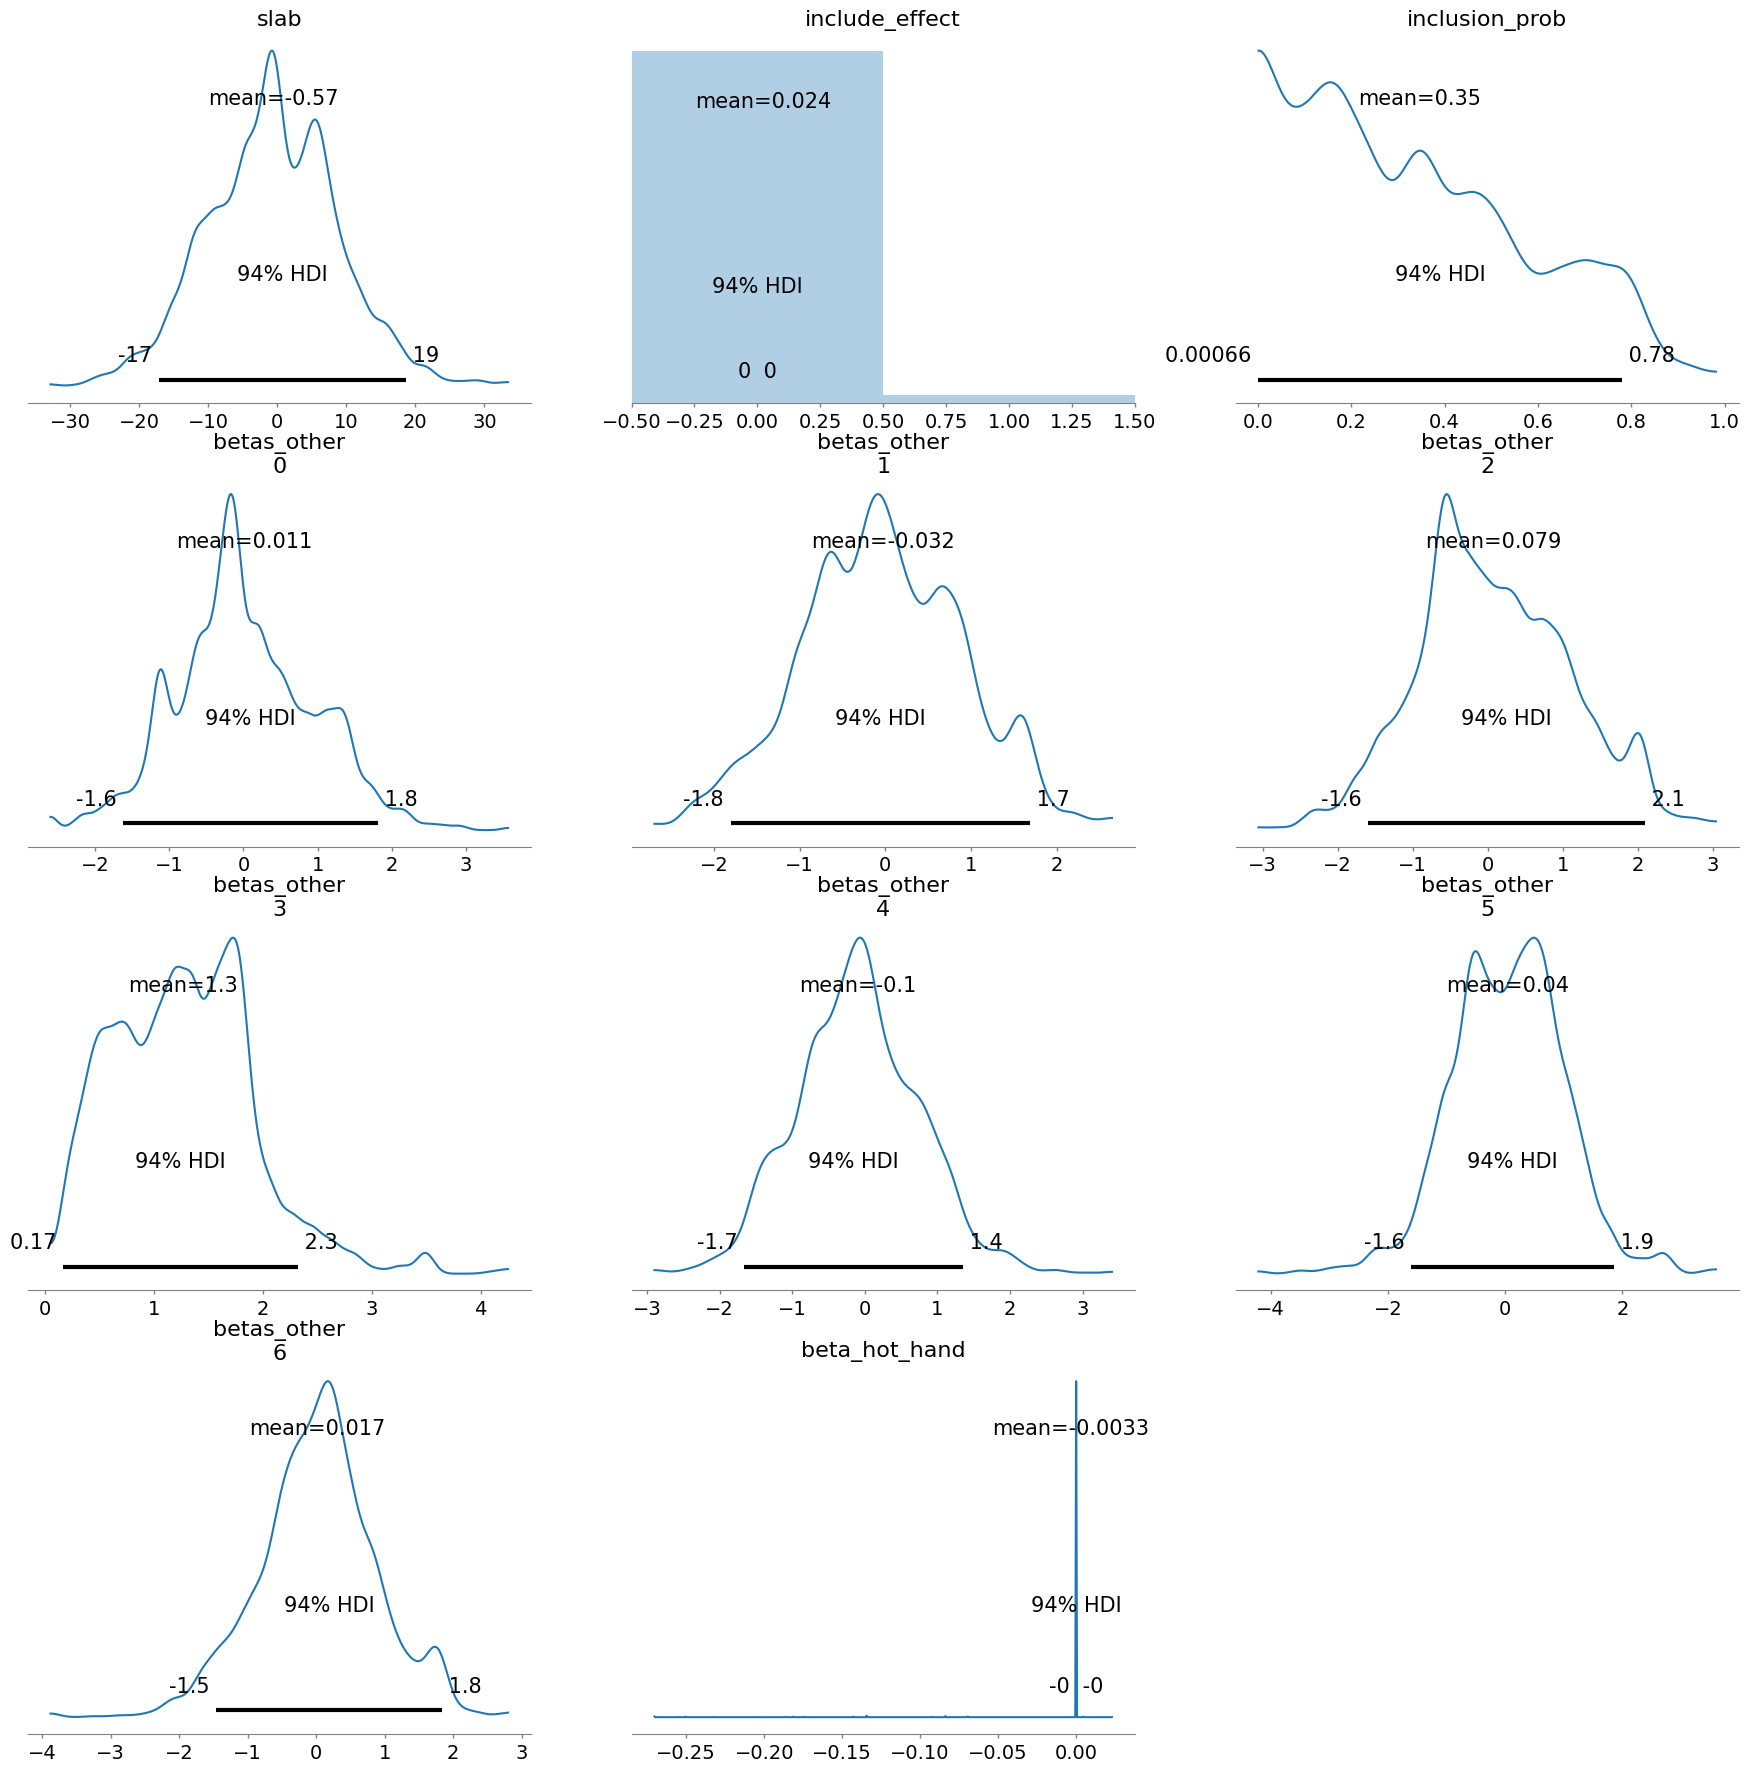

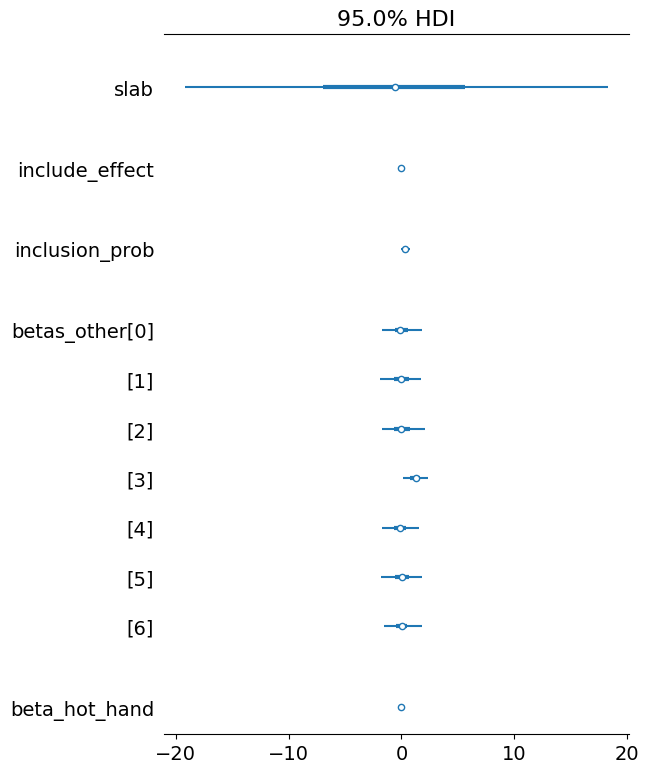

In [ ]:
# Posterior plots
az.plot_posterior(idata, var_names=['slab', 'include_effect', 'inclusion_prob','betas_other', 'beta_hot_hand'])
plt.show()

# Forest plots
az.plot_forest(idata, var_names=['slab', 'include_effect', 'inclusion_prob', 'betas_other', 'beta_hot_hand'], combined=True, hdi_prob=0.95)
plt.show()
